# Phân tích Dữ liệu Câu hỏi Pháp luật

Notebook này sẽ giúp phân tích dữ liệu câu hỏi pháp luật để xây dựng hệ thống phân loại. Chúng ta sẽ tập trung vào:

1. **Khám phá cấu trúc dữ liệu** và hiểu các trường thông tin
2. **Phân tích thống kê** về phân bố các loại câu hỏi
3. **Xử lý văn bản tiếng Việt** cho domain pháp luật
4. **Trực quan hóa** các patterns trong dữ liệu
5. **Feature engineering** cho bài toán phân loại

---

## 1. Import Required Libraries

Import các thư viện cần thiết cho phân tích dữ liệu văn bản tiếng Việt

In [10]:
#import numpy as np
import pandas as pd
#print(np.__version__)
print(pd.__version__)

2.2.3


In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = ['DejaVu Sans']

# Text processing
import re
import string
from collections import Counter

# Vietnamese text processing
try:
    import underthesea
    from underthesea import word_tokenize, pos_tag
    print("✓ underthesea đã được cài đặt")
except ImportError:
    print("⚠️ Chưa cài đặt underthesea. Chạy: pip install underthesea")

# Machine learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

print("✓ Đã import tất cả thư viện cần thiết")

⚠️ Chưa cài đặt underthesea. Chạy: pip install underthesea
✓ Đã import tất cả thư viện cần thiết
✓ Đã import tất cả thư viện cần thiết


## 2. Load and Explore Legal Dataset

Đọc dữ liệu và khám phá cấu trúc ban đầu

In [3]:
# Đọc dữ liệu
df = pd.read_csv('data.csv', sep=';', encoding='utf-8')

print("📊 THÔNG TIN CƠ BẢN VỀ DATASET")
print(f"Số lượng dòng: {len(df):,}")
print(f"Số lượng cột: {len(df.columns)}")
print(f"Kích thước dataset: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📋 CÁC CỘT TRONG DATASET:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")
    
print("\n📈 KIỂU DỮ LIỆU:")
print(df.dtypes)

📊 THÔNG TIN CƠ BẢN VỀ DATASET
Số lượng dòng: 3,629
Số lượng cột: 17
Kích thước dataset: 30.56 MB

📋 CÁC CỘT TRONG DATASET:
 1. label
 2. post_time
 3. question_text
 4. question_note
 5. Liên quan?
 6. question_type
 7. Subject
 8. Type
 9. Action
10. Circumstance
11. related_tags
12. detail_url
13. answer
14. answer_level
15. note_answer
16. key_answer
17. laws

📈 KIỂU DỮ LIỆU:
label             object
post_time         object
question_text     object
question_note     object
Liên quan?        object
question_type     object
Subject           object
Type              object
Action            object
Circumstance      object
related_tags      object
detail_url        object
answer            object
answer_level     float64
note_answer       object
key_answer        object
laws              object
dtype: object


In [4]:
# Kiểm tra missing values
print("🔍 MISSING VALUES:")
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Cột': missing_counts.index,
    'Số lượng missing': missing_counts.values,
    'Phần trăm (%)': missing_percent.values
})

print(missing_df[missing_df['Số lượng missing'] > 0].to_string(index=False))

# Hiển thị 3 mẫu đầu tiên
print("\n📝 MẪU DỮ LIỆU:")
print("="*80)
for i in range(min(3, len(df))):
    print(f"\n🔸 MẪU {i+1}:")
    sample = df.iloc[i]
    print(f"Label: {sample['label']}")
    print(f"Subject: {sample['Subject']}")
    print(f"Type: {sample['Type']}")
    print(f"Action: {sample['Action']}")
    print(f"Question: {sample['question_text'][:200]}...")
    print("-" * 60)

🔍 MISSING VALUES:
          Cột  Số lượng missing  Phần trăm (%)
question_note              2394      65.968586
question_type              1715      47.258198
      Subject              1754      48.332874
         Type              1829      50.399559
       Action              1947      53.651144
 Circumstance              2646      72.912648
 related_tags               763      21.025076
   detail_url                 1       0.027556
 answer_level              1765      48.635988
  note_answer              2319      63.901901
   key_answer              1825      50.289336
         laws              1967      54.202260

📝 MẪU DỮ LIỆU:

🔸 MẪU 1:
Label: Thủ tục khai báo tạm vắng khi rời khỏi nơi cư trú
Subject: VN_lớn_hơn_14
Type: Tạm_trú
Action: Đăng ký/Khai báo
Question: Tôi có hộ khẩu tại Bắc Ninh, vào Sài gòn để làm việc khoảng hơn 1 năm. Nhờ ban biên tập hướng dẫn trường hợp của tôi có cần làm thủ tục khai báo tạm vắng khi rời khỏi nơi cư trú vào TP HCM làm việc để...
------------

## 3. Phân tích Thống kê Mô tả

Phân tích phân bố của các biến phân loại quan trọng

In [5]:
# Phân tích phân bố các biến phân loại
def analyze_categorical_column(df, column_name):
    """Phân tích một cột phân loại"""
    print(f"\n📊 PHÂN TÍCH CỘT: {column_name}")
    print("="*50)
    
    # Đếm giá trị
    value_counts = df[column_name].value_counts()
    value_percent = df[column_name].value_counts(normalize=True) * 100
    
    # Tạo DataFrame để hiển thị
    analysis_df = pd.DataFrame({
        'Giá trị': value_counts.index,
        'Số lượng': value_counts.values,
        'Phần trăm (%)': value_percent.values
    })
    
    print(analysis_df.to_string(index=False))
    print(f"\nTổng số giá trị unique: {df[column_name].nunique()}")
    
    return analysis_df

# Phân tích các cột quan trọng
key_columns = ['Subject', 'Type', 'Action', 'Circumstance']

for col in key_columns:
    if col in df.columns:
        analyze_categorical_column(df, col)


📊 PHÂN TÍCH CỘT: Subject
           Giá trị  Số lượng  Phần trăm (%)
     VN_lớn_hơn_14      1302      69.440000
                NN       400      21.333333
Không có thông tin        89       4.746667
      VN_bé_hơn_14        49       2.613333
     VN_lớn_hơn_15        29       1.546667
     VN_lớn_hơn_16         4       0.213333
     VN_lon_hon_14         2       0.106667

Tổng số giá trị unique: 7

📊 PHÂN TÍCH CỘT: Type
   Giá trị  Số lượng  Phần trăm (%)
   Tạm_trú       821      45.611111
Thường_trú       451      25.055556
   Tạm trú       185      10.277778
   Lưu_trú       161       8.944444
  Tạm_vắng       154       8.555556
  Tạm vắng        12       0.666667
Thường trú        10       0.555556
   Lưu trú         6       0.333333

Tổng số giá trị unique: 8

📊 PHÂN TÍCH CỘT: Action
                        Giá trị  Số lượng  Phần trăm (%)
                Đăng ký tạm trú       510      30.321046
               Đăng ký/Khai báo       407      24.197384
                       Kh

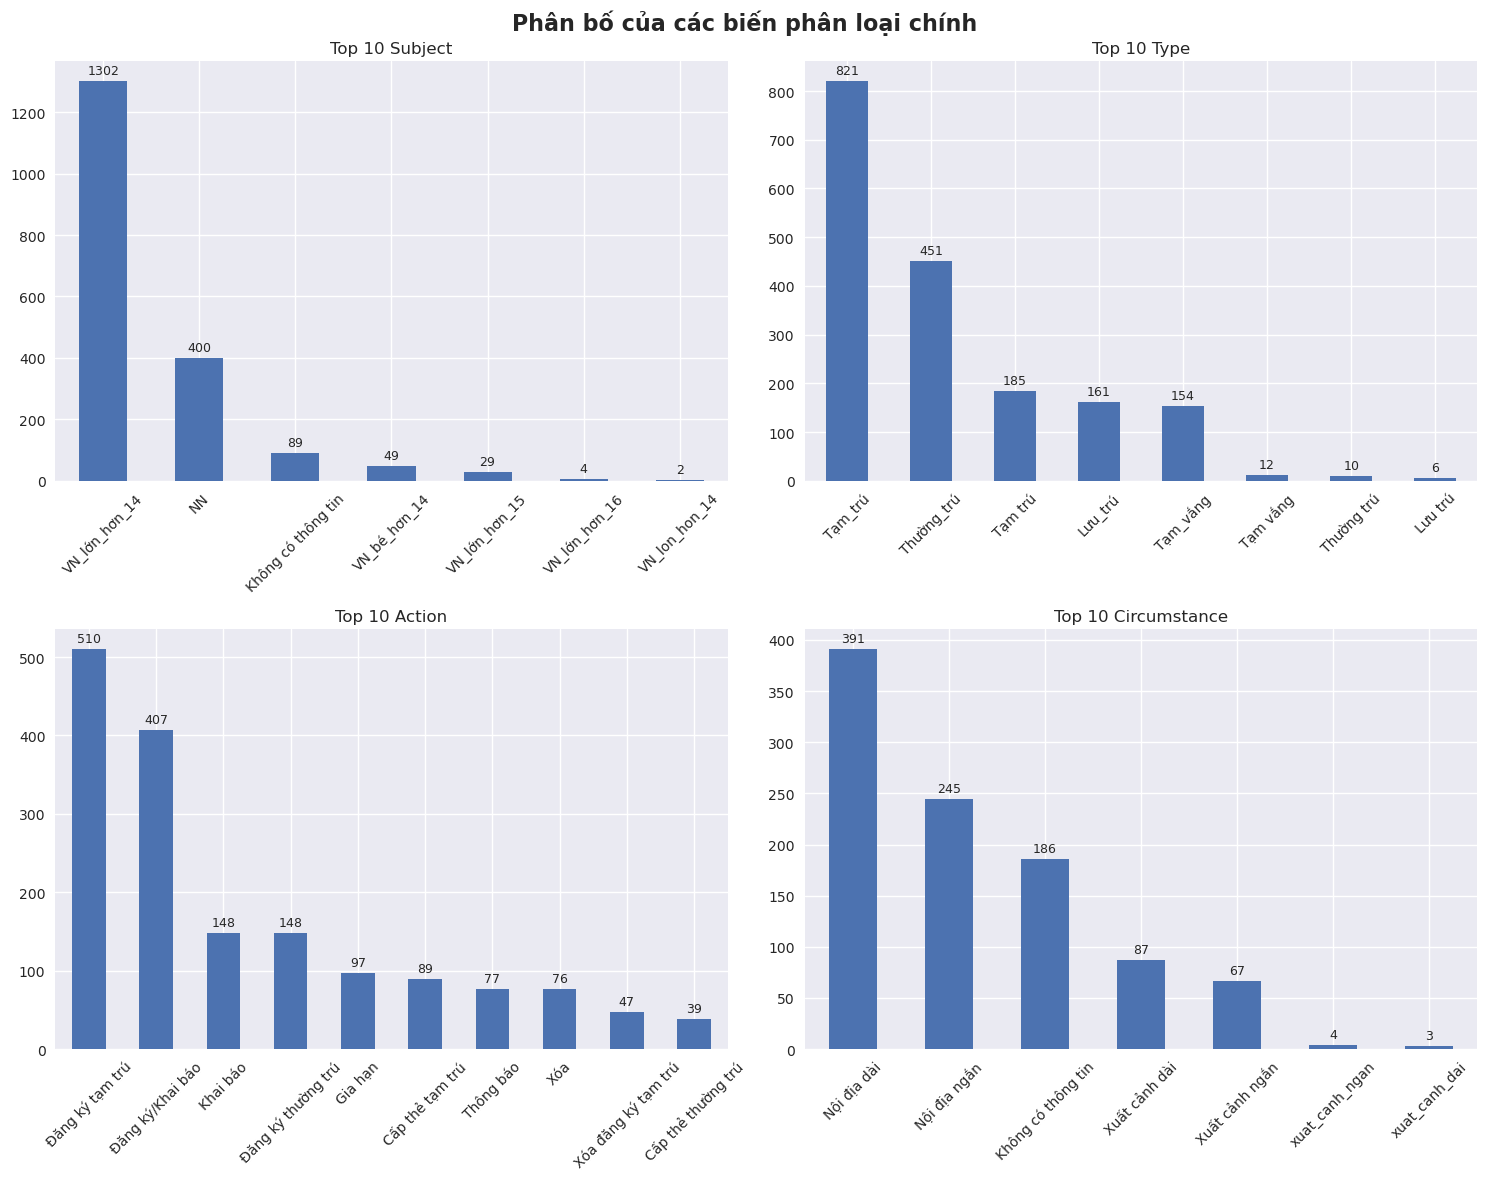

In [6]:
# Tạo visualization cho phân bố dữ liệu
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Phân bố của các biến phân loại chính', fontsize=16, fontweight='bold')

# Danh sách các cột để vẽ biểu đồ
plot_columns = ['Subject', 'Type', 'Action', 'Circumstance']

for idx, col in enumerate(plot_columns):
    if col in df.columns:
        row = idx // 2
        col_idx = idx % 2
        
        # Lấy top 10 giá trị phổ biến nhất
        top_values = df[col].value_counts().head(10)
        
        # Vẽ bar chart
        top_values.plot(kind='bar', ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f'Top 10 {col}')
        axes[row, col_idx].set_xlabel('')
        axes[row, col_idx].tick_params(axis='x', rotation=45)
        
        # Thêm số lượng trên mỗi bar
        for i, v in enumerate(top_values.values):
            axes[row, col_idx].text(i, v + max(top_values.values)*0.01, str(v), 
                                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 4. Phân tích văn bản câu hỏi

Phân tích nội dung văn bản của các câu hỏi pháp luật

📏 THỐNG KÊ ĐỘ DÀI VĂN BẢN:
Độ dài trung bình (ký tự): 327.09
Độ dài median (ký tự): 279.00
Số từ trung bình: 73.64
Số từ median: 63.00

Phân bố độ dài:
count    3629.000000
mean      327.089832
std       192.013881
min        14.000000
25%       185.000000
50%       279.000000
75%       451.000000
max      1564.000000
Name: question_length, dtype: float64


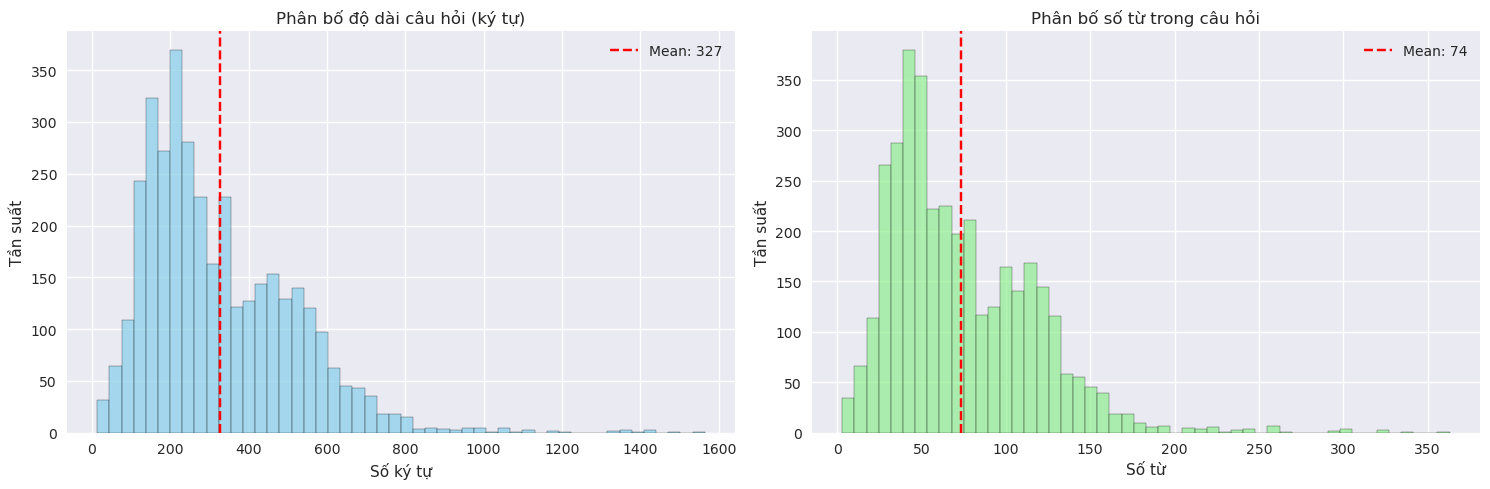

In [7]:
# Phân tích độ dài văn bản
df['question_length'] = df['question_text'].astype(str).apply(len)
df['question_word_count'] = df['question_text'].astype(str).apply(lambda x: len(x.split()))

print("📏 THỐNG KÊ ĐỘ DÀI VĂN BẢN:")
print(f"Độ dài trung bình (ký tự): {df['question_length'].mean():.2f}")
print(f"Độ dài median (ký tự): {df['question_length'].median():.2f}")
print(f"Số từ trung bình: {df['question_word_count'].mean():.2f}")
print(f"Số từ median: {df['question_word_count'].median():.2f}")

print(f"\nPhân bố độ dài:")
print(df['question_length'].describe())

# Vẽ biểu đồ phân bố độ dài
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram độ dài ký tự
axes[0].hist(df['question_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Phân bố độ dài câu hỏi (ký tự)')
axes[0].set_xlabel('Số ký tự')
axes[0].set_ylabel('Tần suất')
axes[0].axvline(df['question_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["question_length"].mean():.0f}')
axes[0].legend()

# Histogram số từ
axes[1].hist(df['question_word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Phân bố số từ trong câu hỏi')
axes[1].set_xlabel('Số từ')
axes[1].set_ylabel('Tần suất')
axes[1].axvline(df['question_word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["question_word_count"].mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

In [8]:
# Hàm làm sạch văn bản tiếng Việt
def clean_vietnamese_text(text):
    """Làm sạch văn bản tiếng Việt"""
    if pd.isna(text):
        return ""
    
    # Chuyển về lowercase
    text = str(text).lower()
    
    # Loại bỏ HTML tags nếu có
    text = re.sub(r'<[^>]+>', '', text)
    
    # Loại bỏ URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Loại bỏ email
    text = re.sub(r'\S+@\S+', '', text)
    
    # Loại bỏ số điện thoại
    text = re.sub(r'(\+84|0)[0-9]{9,10}', '', text)
    
    # Chuẩn hóa khoảng trắng
    text = re.sub(r'\s+', ' ', text)
    
    # Loại bỏ ký tự đặc biệt nhưng giữ lại dấu câu cơ bản
    text = re.sub(r'[^\w\s\.,;:!?\-()]', '', text)
    
    return text.strip()

# Áp dụng làm sạch văn bản
print("🧹 Đang làm sạch văn bản...")
df['question_cleaned'] = df['question_text'].apply(clean_vietnamese_text)

# So sánh trước và sau khi làm sạch
print("\n📝 VÍ DỤ VĂN BẢN TRƯỚC VÀ SAU KHI LÀM SẠCH:")
for i in range(2):
    print(f"\n🔸 Mẫu {i+1}:")
    print(f"Trước: {df['question_text'].iloc[i][:150]}...")
    print(f"Sau:  {df['question_cleaned'].iloc[i][:150]}...")
    print("-" * 80)

🧹 Đang làm sạch văn bản...

📝 VÍ DỤ VĂN BẢN TRƯỚC VÀ SAU KHI LÀM SẠCH:

🔸 Mẫu 1:
Trước: Tôi có hộ khẩu tại Bắc Ninh, vào Sài gòn để làm việc khoảng hơn 1 năm. Nhờ ban biên tập hướng dẫn trường hợp của tôi có cần làm thủ tục khai báo tạm v...
Sau:  tôi có hộ khẩu tại bắc ninh, vào sài gòn để làm việc khoảng hơn 1 năm. nhờ ban biên tập hướng dẫn trường hợp của tôi có cần làm thủ tục khai báo tạm v...
--------------------------------------------------------------------------------

🔸 Mẫu 2:
Trước: Chào ban biên tập, hiện tại em đã xuất cảnh ra nước ngoài để học tập trong thời gian dài. Gần đây em có biết thông tin ai rời khỏi địa phương thì phải...
Sau:  chào ban biên tập, hiện tại em đã xuất cảnh ra nước ngoài để học tập trong thời gian dài. gần đây em có biết thông tin ai rời khỏi địa phương thì phải...
--------------------------------------------------------------------------------


## 5. Phân tích từ khóa và Word Cloud

Tìm hiểu các từ khóa phổ biến trong domain pháp luật

🔍 PHÂN TÍCH TỪ KHÓA TOÀN BỘ DATASET:
Top 30 từ xuất hiện nhiều nhất:
 1. trú                  - 3572 lần
 2. định                 - 3401 lần
 3. quy                  - 3103 lần
 4. ban                  - 3057 lần
 5. tại                  - 3001 lần
 6. đăng                 - 2897 lần
 7. biên                 - 2882 lần
 8. lưu                  - 2494 lần
 9. nào?                 - 2390 lần
10. tạm                  - 2375 lần
11. công                 - 1926 lần
12. làm                  - 1901 lần
13. hiện                 - 1882 lần
14. việc                 - 1686 lần
15. tập                  - 1671 lần
16. người                - 1657 lần
17. trữ                  - 1641 lần
18. mong                 - 1640 lần
19. nhận                 - 1548 lần
20. không?               - 1505 lần
21. vấn                  - 1503 lần
22. thường               - 1433 lần
23. hỏi                  - 1426 lần
24. thành                - 1426 lần
25. cảm                  - 1336 lần
26. giải                 - 1263

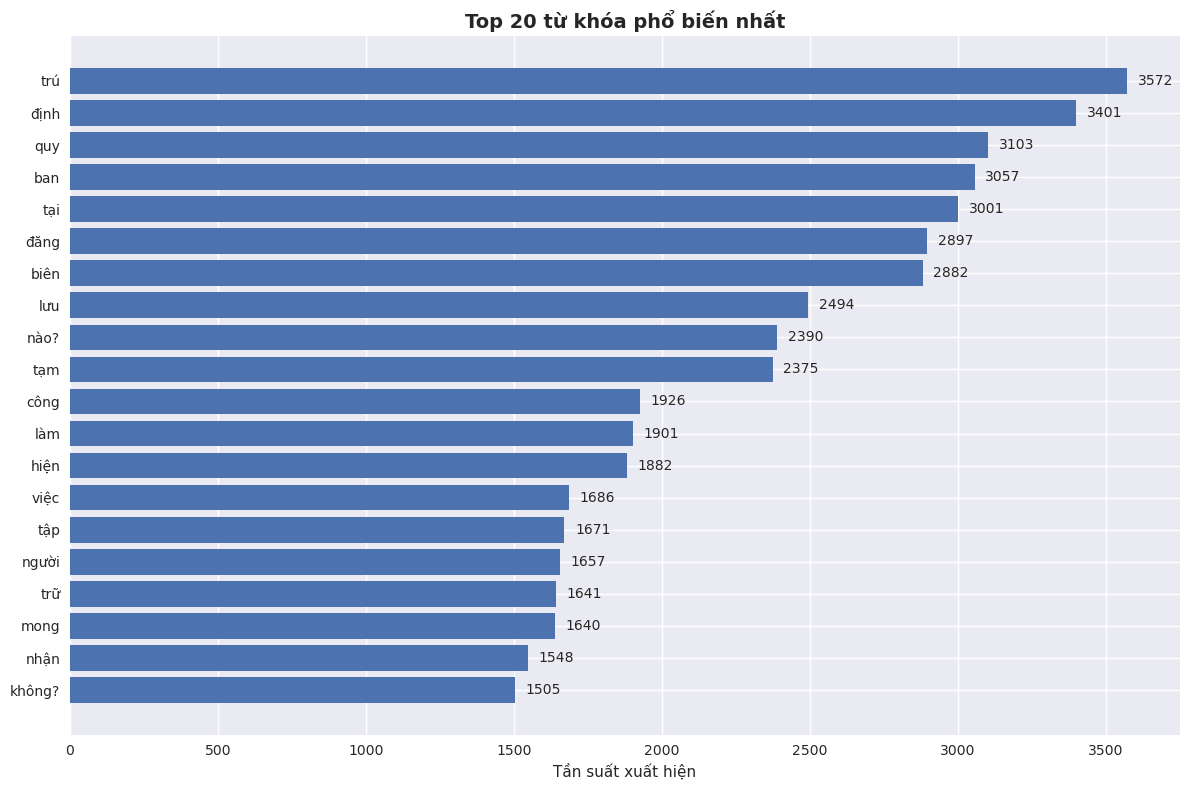

In [9]:
# Danh sách stopwords tiếng Việt
vietnamese_stopwords = {
    'tôi', 'bạn', 'anh', 'chị', 'em', 'chúng', 'ta', 'chúng tôi', 'chúng ta',
    'và', 'hay', 'hoặc', 'nhưng', 'mà', 'vì', 'nên', 'do', 'để', 'khi', 'nếu',
    'thì', 'rằng', 'là', 'có', 'được', 'sẽ', 'đã', 'đang', 'sẽ', 'phải',
    'trong', 'của', 'cho', 'về', 'với', 'từ', 'đến', 'trên', 'dưới', 'giữa',
    'này', 'đó', 'kia', 'nào', 'đâu', 'sao', 'gì', 'ai', 'như', 'thế',
    'các', 'những', 'mọi', 'tất', 'cả', 'nhiều', 'ít', 'một', 'hai', 'ba',
    'không', 'chưa', 'đừng', 'chẳng', 'hãy', 'xin', 'vào', 'ra', 'lên', 'xuống'
}

def get_word_frequency(texts, top_n=30):
    """Tính tần suất từ xuất hiện"""
    all_words = []
    
    for text in texts:
        if pd.notna(text):
            # Tách từ đơn giản (có thể thay bằng underthesea.word_tokenize nếu đã cài)
            words = text.lower().split()
            # Lọc bỏ stopwords và từ ngắn
            words = [w for w in words if len(w) > 2 and w not in vietnamese_stopwords]
            all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

# Phân tích từ khóa cho toàn bộ dataset
print("🔍 PHÂN TÍCH TỪ KHÓA TOÀN BỘ DATASET:")
word_freq = get_word_frequency(df['question_cleaned'], top_n=30)

print("Top 30 từ xuất hiện nhiều nhất:")
for i, (word, count) in enumerate(word_freq, 1):
    print(f"{i:2d}. {word:20s} - {count:4d} lần")

# Vẽ biểu đồ tần suất từ
plt.figure(figsize=(12, 8))
words, counts = zip(*word_freq[:20])
plt.barh(range(len(words)), counts)
plt.yticks(range(len(words)), words)
plt.xlabel('Tần suất xuất hiện')
plt.title('Top 20 từ khóa phổ biến nhất', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Thêm giá trị lên các thanh
for i, count in enumerate(counts):
    plt.text(count + max(counts)*0.01, i, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Tạo Word Cloud
try:
    # Kết hợp tất cả văn bản đã làm sạch
    all_text = ' '.join(df['question_cleaned'].dropna().astype(str))
    
    # Tạo word cloud
    wordcloud = WordCloud(
        width=1200, 
        height=600, 
        background_color='white',
        colormap='viridis',
        max_words=100,
        font_path=None  # Có thể chỉ định font tiếng Việt nếu cần
    ).generate(all_text)
    
    # Vẽ word cloud
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Từ khóa phổ biến trong câu hỏi pháp luật', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Không thể tạo word cloud: {e}")
    print("Có thể cần cài đặt: pip install wordcloud")

## 6. Phân tích Type "Thường trú"

Tập trung phân tích các câu hỏi liên quan đến Type "Thường trú"

In [ ]:
# Lọc dữ liệu chỉ Type "Thường_trú"
thuong_tru_df = df[df['Type'] == 'Thường_trú'].copy()

print("🏠 PHÂN TÍCH TYPE 'THƯỜNG TRÚ'")
print("="*50)
print(f"Tổng số câu hỏi về Thường trú: {len(thuong_tru_df):,}")
print(f"Chiếm {len(thuong_tru_df)/len(df)*100:.2f}% tổng dataset")

print("\n📊 PHÂN BỐ THEO SUBJECT:")
subject_counts = thuong_tru_df['Subject'].value_counts()
for subject, count in subject_counts.items():
    percent = count/len(thuong_tru_df)*100
    print(f"  • {subject}: {count:,} câu hỏi ({percent:.1f}%)")

print("\n📋 PHÂN BỐ THEO ACTION:")
action_counts = thuong_tru_df['Action'].value_counts()
for action, count in action_counts.items():
    percent = count/len(thuong_tru_df)*100
    print(f"  • {action}: {count:,} câu hỏi ({percent:.1f}%)")

# Ma trận Subject vs Action
print("\n📈 MA TRẬN SUBJECT VS ACTION:")
crosstab = pd.crosstab(thuong_tru_df['Subject'], thuong_tru_df['Action'], margins=True)
print(crosstab)

In [ ]:
# Visualize phân bố Subject và Action cho Type Thường trú
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Phân tích chi tiết Type "Thường trú"', fontsize=16, fontweight='bold')

# 1. Phân bố Subject
subject_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Phân bố theo Subject')
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(subject_counts.values):
    axes[0,0].text(i, v + max(subject_counts.values)*0.01, str(v), ha='center', va='bottom')

# 2. Phân bố Action
action_counts.plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Phân bố theo Action')
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(action_counts.values):
    axes[0,1].text(i, v + max(action_counts.values)*0.01, str(v), ha='center', va='bottom')

# 3. Heatmap Subject vs Action
crosstab_percent = pd.crosstab(thuong_tru_df['Subject'], thuong_tru_df['Action'], normalize='index') * 100
sns.heatmap(crosstab_percent, annot=True, fmt='.1f', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('% Action theo Subject')
axes[1,0].set_xlabel('Action')
axes[1,0].set_ylabel('Subject')

# 4. Độ dài câu hỏi theo Subject
thuong_tru_df.boxplot(column='question_word_count', by='Subject', ax=axes[1,1])
axes[1,1].set_title('Phân bố độ dài câu hỏi theo Subject')
axes[1,1].set_xlabel('Subject')
axes[1,1].set_ylabel('Số từ')

plt.tight_layout()
plt.show()

## 8. Lọc dữ liệu cho bài toán phân loại Action

Loại bỏ dữ liệu không liên quan và tập trung vào Type "Thường trú"

In [4]:
# Lọc dữ liệu cho bài toán phân loại Action Type "Thường trú"
print("🔍 LỌC DỮ LIỆU CHO BÀI TOÁN PHÂN LOẠI ACTION TYPE 'THƯỜNG TRÚ'")
print("="*70)

# Kiểm tra dữ liệu trước khi lọc
print(f"Số dòng ban đầu: {len(df):,}")
print(f"Số dòng có 'Liên quan?' = 'Yes': {len(df[df['Liên quan?'] == 'Yes']):,}")
print(f"Số dòng có 'Liên quan?' = 'No': {len(df[df['Liên quan?'] == 'No']):,}")
print(f"Số dòng có Type = 'Thường_trú': {len(df[df['Type'] == 'Thường_trú']):,}")

# Bước 1: Chỉ giữ lại các dòng có 'Liên quan?' = 'Yes'
df_filtered = df[df['Liên quan?'] == 'Yes'].copy()
print(f"\n✅ Sau khi lọc 'Liên quan?' = 'Yes': {len(df_filtered):,} dòng")

# Bước 2: Chỉ giữ lại Type = 'Thường_trú' (nếu muốn tập trung vào Thường trú)
df_thuong_tru = df_filtered[df_filtered['Type'] == 'Thường_trú'].copy()
print(f"✅ Dữ liệu Type 'Thường_trú': {len(df_thuong_tru):,} dòng")

# Bước 3: Loại bỏ cột post_time không cần thiết
columns_to_drop = ['post_time']
if 'post_time' in df_thuong_tru.columns:
    df_thuong_tru = df_thuong_tru.drop(columns=columns_to_drop)
    print(f"✅ Đã loại bỏ cột: {columns_to_drop}")

print(f"\n📊 DATASET SAU KHI LỌC:")
print(f"- Số dòng: {len(df_thuong_tru):,}")
print(f"- Số cột: {len(df_thuong_tru.columns)}")
print(f"- Các cột còn lại: {list(df_thuong_tru.columns)}")

# Kiểm tra phân bố Subject và Action trong dữ liệu đã lọc
print(f"\n📈 PHÂN BỐ SUBJECT:")
for subject, count in df_thuong_tru['Subject'].value_counts().items():
    print(f"  • {subject}: {count:,} câu hỏi")

print(f"\n📈 PHÂN BỐ ACTION:")
for action, count in df_thuong_tru['Action'].value_counts().items():
    print(f"  • {action}: {count:,} câu hỏi")

🔍 LỌC DỮ LIỆU CHO BÀI TOÁN PHÂN LOẠI ACTION TYPE 'THƯỜNG TRÚ'
Số dòng ban đầu: 3,629
Số dòng có 'Liên quan?' = 'Yes': 1,854
Số dòng có 'Liên quan?' = 'No': 1,775
Số dòng có Type = 'Thường_trú': 451

✅ Sau khi lọc 'Liên quan?' = 'Yes': 1,854 dòng
✅ Dữ liệu Type 'Thường_trú': 450 dòng
✅ Đã loại bỏ cột: ['post_time']

📊 DATASET SAU KHI LỌC:
- Số dòng: 450
- Số cột: 16
- Các cột còn lại: ['label', 'question_text', 'question_note', 'Liên quan?', 'question_type', 'Subject', 'Type', 'Action', 'Circumstance', 'related_tags', 'detail_url', 'answer', 'answer_level', 'note_answer', 'key_answer', 'laws']

📈 PHÂN BỐ SUBJECT:
  • VN_lớn_hơn_14: 349 câu hỏi
  • NN: 67 câu hỏi
  • VN_bé_hơn_14: 32 câu hỏi
  • VN_lớn_hơn_15: 1 câu hỏi
  • VN_lon_hon_14: 1 câu hỏi

📈 PHÂN BỐ ACTION:
  • Đăng ký/Khai báo: 160 câu hỏi
  • Đăng ký thường trú: 148 câu hỏi
  • Xóa: 53 câu hỏi
  • Cấp thẻ thường trú: 39 câu hỏi
  • Xóa đăng ký thường trú: 28 câu hỏi
  • Điều chỉnh thông tin thường trú: 4 câu hỏi
  • Chuyển đă


📊 MA TRẬN SUBJECT VS ACTION (SAU KHI LỌC):
Action         Chuyển đăng ký  Cấp thẻ thường trú  Gia hạn  Xóa  \
Subject                                                           
NN                          0                  39        2    2   
VN_bé_hơn_14                0                   0        0    2   
VN_lon_hon_14               0                   0        0    0   
VN_lớn_hơn_14               2                   0        0   49   
VN_lớn_hơn_15               0                   0        0    0   
All                         2                  39        2   53   

Action         Xóa đăng ký thường trú  Điều chỉnh  \
Subject                                             
NN                                  0           0   
VN_bé_hơn_14                        0           0   
VN_lon_hon_14                       0           0   
VN_lớn_hơn_14                      28           1   
VN_lớn_hơn_15                       0           0   
All                                28           

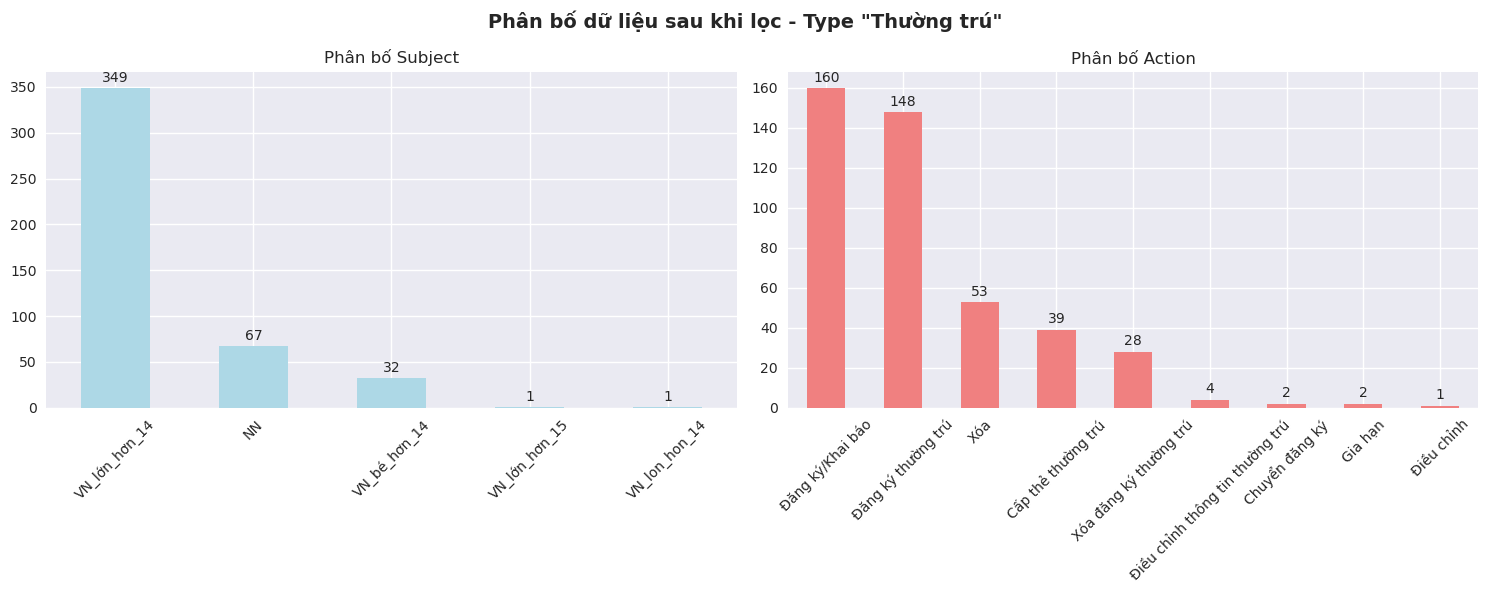


💾 Đã lưu dataset đã lọc vào file: 'data_thuong_tru_filtered.csv'


In [14]:
# Hiển thị ma trận Subject vs Action sau khi lọc
print("\n📊 MA TRẬN SUBJECT VS ACTION (SAU KHI LỌC):")
crosstab_filtered = pd.crosstab(df_thuong_tru['Subject'], df_thuong_tru['Action'], margins=True)
print(crosstab_filtered)

# Tạo visualization cho dữ liệu đã lọc
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Phân bố dữ liệu sau khi lọc - Type "Thường trú"', fontsize=14, fontweight='bold')

# Subject distribution
subject_counts_filtered = df_thuong_tru['Subject'].value_counts()
subject_counts_filtered.plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title('Phân bố Subject')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(subject_counts_filtered.values):
    axes[0].text(i, v + max(subject_counts_filtered.values)*0.01, str(v), ha='center', va='bottom')

# Action distribution
action_counts_filtered = df_thuong_tru['Action'].value_counts()
action_counts_filtered.plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Phân bố Action')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(action_counts_filtered.values):
    axes[1].text(i, v + max(action_counts_filtered.values)*0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Lưu dataset đã lọc
df_thuong_tru.to_csv('data_thuong_tru_filtered.csv', index=False, encoding='utf-8')
print("\n💾 Đã lưu dataset đã lọc vào file: 'data_thuong_tru_filtered.csv'")

## 9. Làm sạch và chuẩn hóa dữ liệu

Xử lý các vấn đề về chất lượng dữ liệu và chuẩn hóa Action

In [7]:
# Làm sạch và chuẩn hóa dữ liệu
print("🧹 LÀM SẠCH VÀ CHUẨN HÓA DỮ LIỆU")
print("="*50)

# Kiểm tra dữ liệu trước khi làm sạch
print("📊 TRƯỚC KHI LÀM SẠCH:")
print(f"Tổng số dòng: {len(df_thuong_tru)}")
print("Subject distribution:")
for subject, count in df_thuong_tru['Subject'].value_counts().items():
    print(f"  • {subject}: {count}")
print("Action distribution:")
for action, count in df_thuong_tru['Action'].value_counts().items():
    print(f"  • {action}: {count}")

# Bước 1: Loại bỏ các Subject có lỗi chính tả
print(f"\n🔧 BƯỚC 1: Loại bỏ Subject lỗi chính tả")
subjects_to_remove = ['VN_lớn_hơn_15', 'VN_lon_hon_14']
df_clean = df_thuong_tru[~df_thuong_tru['Subject'].isin(subjects_to_remove)].copy()
print(f"Đã loại bỏ {len(df_thuong_tru) - len(df_clean)} dòng với Subject lỗi")
print(f"Còn lại: {len(df_clean)} dòng")

# Bước 2: Hợp nhất Action 'Đăng ký/Khai báo' với 'Đăng ký thường trú'
print(f"\n🔧 BƯỚC 2: Hợp nhất Action")
print(f"Trước: 'Đăng ký/Khai báo' có {len(df_clean[df_clean['Action'] == 'Đăng ký/Khai báo'])} dòng")
print(f"Trước: 'Đăng ký thường trú' có {len(df_clean[df_clean['Action'] == 'Đăng ký thường trú'])} dòng")

# Thay thế 'Đăng ký/Khai báo' thành 'Đăng ký thường trú'
df_clean.loc[df_clean['Action'] == 'Đăng ký/Khai báo', 'Action'] = 'Đăng ký thường trú'

print(f"Sau: 'Đăng ký thường trú' có {len(df_clean[df_clean['Action'] == 'Đăng ký thường trú'])} dòng")

# Bước 3: Hợp nhất Action 'Điều chỉnh' với 'Điều chỉnh thông tin thường trú'
print(f"\n🔧 BƯỚC 3: Hợp nhất Action 'Điều chỉnh'")
print(f"Trước: 'Điều chỉnh' có {len(df_clean[df_clean['Action'] == 'Điều chỉnh'])} dòng")
print(f"Trước: 'Điều chỉnh thông tin thường trú' có {len(df_clean[df_clean['Action'] == 'Điều chỉnh thông tin thường trú'])} dòng")

# Thay thế 'Điều chỉnh' thành 'Điều chỉnh thông tin thường trú'
df_clean.loc[df_clean['Action'] == 'Điều chỉnh', 'Action'] = 'Điều chỉnh thông tin thường trú'

print(f"Sau: 'Điều chỉnh thông tin thường trú' có {len(df_clean[df_clean['Action'] == 'Điều chỉnh thông tin thường trú'])} dòng")

# Kiểm tra kết quả sau khi làm sạch
print(f"\n✅ SAU KHI LÀM SẠCH:")
print(f"Tổng số dòng: {len(df_clean)}")
print("Subject distribution:")
for subject, count in df_clean['Subject'].value_counts().items():
    print(f"  • {subject}: {count}")
print("Action distribution:")
for action, count in df_clean['Action'].value_counts().items():
    print(f"  • {action}: {count}")

🧹 LÀM SẠCH VÀ CHUẨN HÓA DỮ LIỆU
📊 TRƯỚC KHI LÀM SẠCH:
Tổng số dòng: 450
Subject distribution:
  • VN_lớn_hơn_14: 349
  • NN: 67
  • VN_bé_hơn_14: 32
  • VN_lớn_hơn_15: 1
  • VN_lon_hon_14: 1
Action distribution:
  • Đăng ký/Khai báo: 160
  • Đăng ký thường trú: 148
  • Xóa: 53
  • Cấp thẻ thường trú: 39
  • Xóa đăng ký thường trú: 28
  • Điều chỉnh thông tin thường trú: 4
  • Chuyển đăng ký: 2
  • Gia hạn: 2
  • Điều chỉnh: 1

🔧 BƯỚC 1: Loại bỏ Subject lỗi chính tả
Đã loại bỏ 2 dòng với Subject lỗi
Còn lại: 448 dòng

🔧 BƯỚC 2: Hợp nhất Action
Trước: 'Đăng ký/Khai báo' có 159 dòng
Trước: 'Đăng ký thường trú' có 147 dòng
Sau: 'Đăng ký thường trú' có 306 dòng

🔧 BƯỚC 3: Hợp nhất Action 'Điều chỉnh'
Trước: 'Điều chỉnh' có 1 dòng
Trước: 'Điều chỉnh thông tin thường trú' có 4 dòng
Sau: 'Điều chỉnh thông tin thường trú' có 5 dòng

✅ SAU KHI LÀM SẠCH:
Tổng số dòng: 448
Subject distribution:
  • VN_lớn_hơn_14: 349
  • NN: 67
  • VN_bé_hơn_14: 32
Action distribution:
  • Đăng ký thường trú: 306


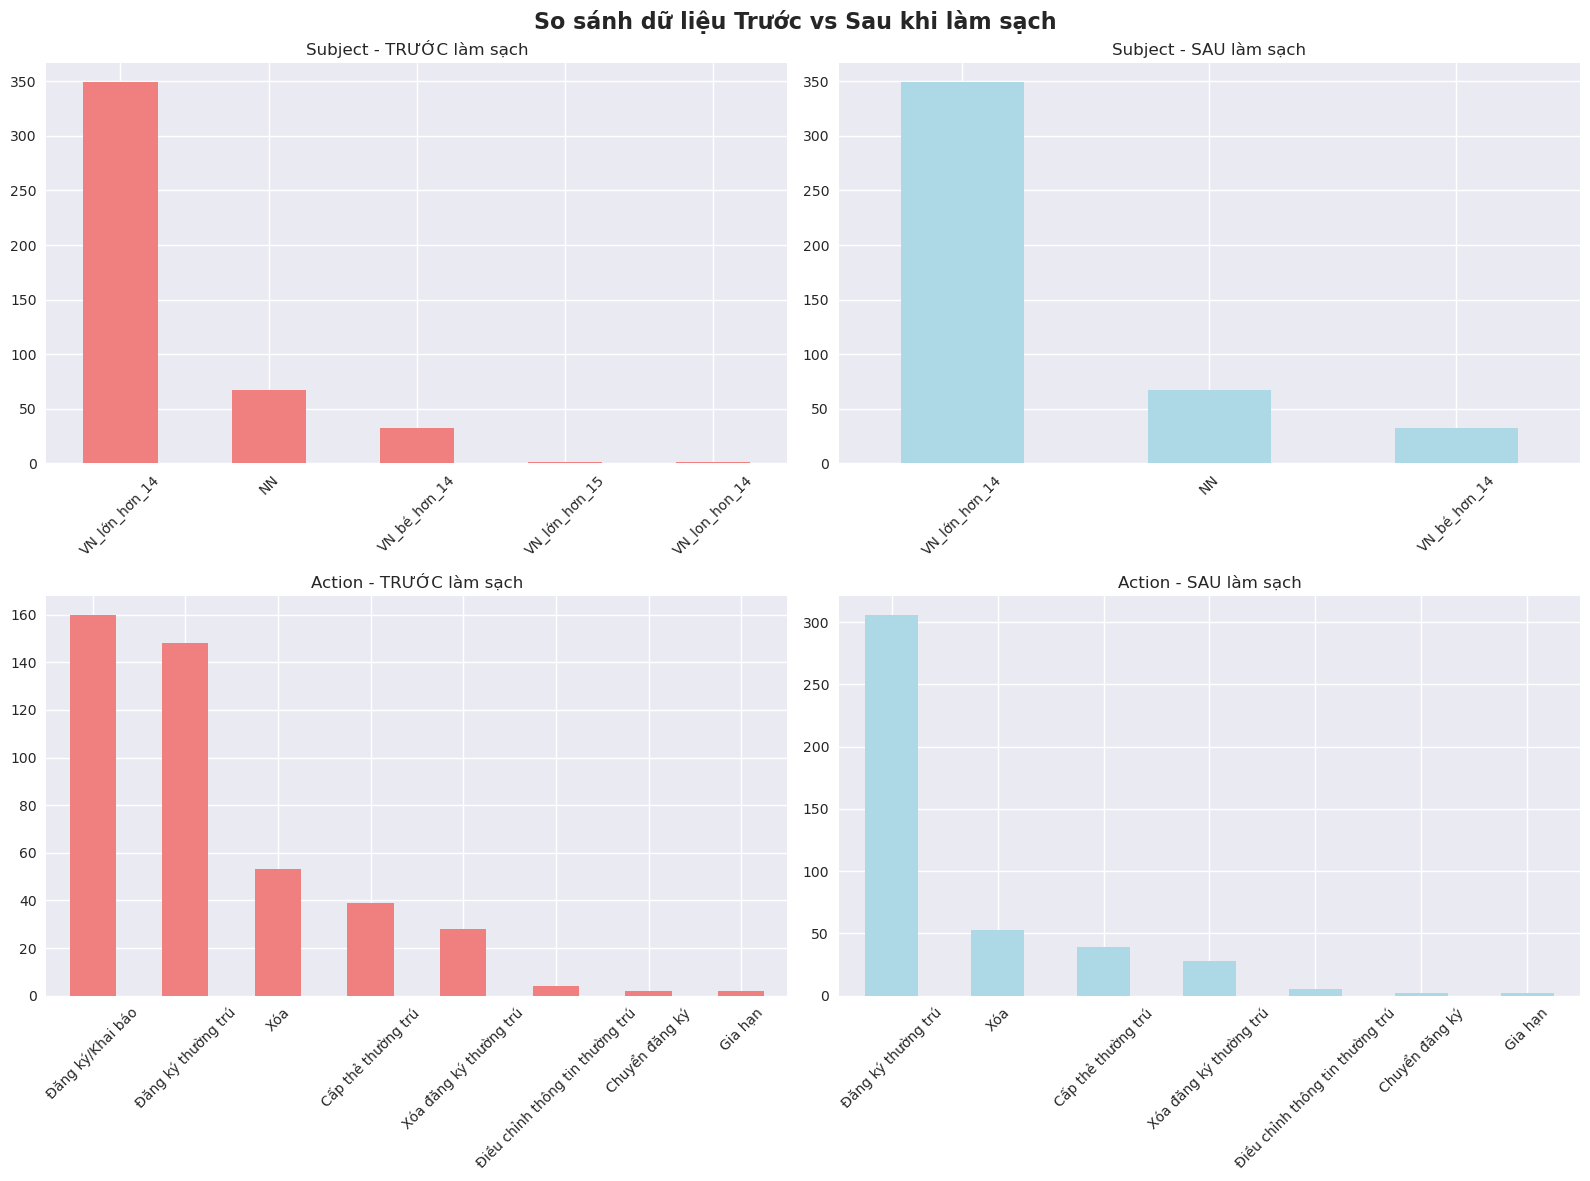


📊 MA TRẬN SUBJECT VS ACTION (SAU KHI LÀM SẠCH):
Action         Chuyển đăng ký  Cấp thẻ thường trú  Gia hạn  Xóa  \
Subject                                                           
NN                          0                  39        2    2   
VN_bé_hơn_14                0                   0        0    2   
VN_lớn_hơn_14               2                   0        0   49   
All                         2                  39        2   53   

Action         Xóa đăng ký thường trú  Điều chỉnh thông tin thường trú  \
Subject                                                                  
NN                                  0                                0   
VN_bé_hơn_14                        0                                0   
VN_lớn_hơn_14                      28                                5   
All                                28                                5   

Action         Đăng ký thường trú  All  
Subject                                 
NN                   

In [8]:
# Tạo visualization so sánh trước và sau khi làm sạch
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('So sánh dữ liệu Trước vs Sau khi làm sạch', fontsize=16, fontweight='bold')

# Trước làm sạch - Subject
df_thuong_tru['Subject'].value_counts().plot(kind='bar', ax=axes[0,0], color='lightcoral')
axes[0,0].set_title('Subject - TRƯỚC làm sạch')
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='x', rotation=45)

# Sau làm sạch - Subject
df_clean['Subject'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightblue')
axes[0,1].set_title('Subject - SAU làm sạch')
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='x', rotation=45)

# Trước làm sạch - Action (top 8)
df_thuong_tru['Action'].value_counts().head(8).plot(kind='bar', ax=axes[1,0], color='lightcoral')
axes[1,0].set_title('Action - TRƯỚC làm sạch')
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='x', rotation=45)

# Sau làm sạch - Action (top 8)
df_clean['Action'].value_counts().head(8).plot(kind='bar', ax=axes[1,1], color='lightblue')
axes[1,1].set_title('Action - SAU làm sạch')
axes[1,1].set_xlabel('')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Ma trận Subject vs Action sau khi làm sạch
print("\n📊 MA TRẬN SUBJECT VS ACTION (SAU KHI LÀM SẠCH):")
crosstab_clean = pd.crosstab(df_clean['Subject'], df_clean['Action'], margins=True)
print(crosstab_clean)

# Lưu dataset đã làm sạch
df_clean.to_csv('data_thuong_tru_clean.csv', index=False, encoding='utf-8')
print(f"\n💾 Đã lưu dataset sạch vào file: 'data_thuong_tru_clean.csv'")
print(f"📈 Kích thước cuối cùng: {len(df_clean)} dòng x {len(df_clean.columns)} cột")